Преобразовала айдишник пользователя и соответствующую группу в словарь, где айди пользователя - значение, а группа ключ. Таким образом имеются уникальные комбинации айди пользователя - группа. Точно также сделала с дополнительным файлом. Затем создала функцию, которая добаляет новые айди и их группу в первый словарь, если они там отсутствуют. Далее преобразовала словари в датафреймы для удобства в дальнейшей работе. 

In [31]:
def metrics(new_ids):
    group_ids = groups.set_index('id').T.to_dict('list')
    group_ids_add = pd.read_csv(new_ids).set_index('id').T.to_dict('list')

    for id in group_ids_add.keys():
        if id not in group_ids.keys():
            group_ids.update(group_ids_add)
            group_ids_df = pd.DataFrame(group_ids.items(), columns=['id', 'grp'])
            group_ids_df = group_ids_df.explode('grp')

    is_paid_with_group = group_ids_df.merge(checks, how='right',  right_on='student_id',left_on='id')
    is_paid_with_group = is_paid_with_group.drop(columns = 'student_id')
    is_paid_with_group ['rev'] = is_paid_with_group.rev.astype(float)
    active_studs_with_group = active_studs.merge(group_ids_df, how='left', left_on='student_id',right_on='id')
    active_studs_with_group = active_studs_with_group.drop(columns = 'id')
    active_studs_with_checks = active_studs_with_group.merge(checks, how='left', on='student_id').fillna(0)

    # Расчет метрик
    
    ARPU_add = active_studs_with_checks.groupby(['grp'], as_index = False).agg({'rev':'mean'})
    ARPPU_add = is_paid_with_group.groupby(['grp'], as_index = False).agg({'rev':'mean'})
    CR_add_1 = is_paid_with_group.groupby(['grp'], as_index = False).agg({'id':'count'})
    CR_add_2 = active_studs_with_checks.groupby(['grp'], as_index = False).agg({'student_id':'count'})
    CR_add = CR_add_1.merge(CR_add_2, how='left', on='grp')
    CR_add ['CR'] = CR_add.id * 100 / CR_add.student_id
    all_metrics = CR_add.merge(ARPPU_add, how = 'left', on = 'grp')
    all_metrics = all_metrics.rename(columns = {'rev':'ARPPU'})
    all_metrics = all_metrics.merge(ARPU_add, how = 'left', on = 'grp')
    all_metrics = all_metrics.rename(columns = {'rev':'ARPU'})
    all_metrics = all_metrics.drop(columns = ['id','student_id'])
    
    # Построение графиков
    
    fig, axs = plt.subplots(1, 3, figsize = (20, 10))
    
    ax = sns.barplot(ax = axs[0], x = 'grp', y = 'CR', data = all_metrics)
    bx = sns.barplot(ax = axs[1], x = 'grp', y = 'ARPU', data = all_metrics)
    cx = sns.barplot(ax = axs[2], x = 'grp', y = 'ARPPU', data = all_metrics)
    
    return all_metrics, ax, bx, cx

In [32]:
# Здесь нужно будет подгружать директорию файла с новыми пользователями

path_to_file = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-z-baranchieva/untitled_folder/final_project/Проект_2_group_add.csv'

(  grp        CR        ARPPU       ARPU
 0   A  6.970684   860.710280  47.439739
 1   B  6.374209  1106.997699  57.864567,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1d78d10a20>)

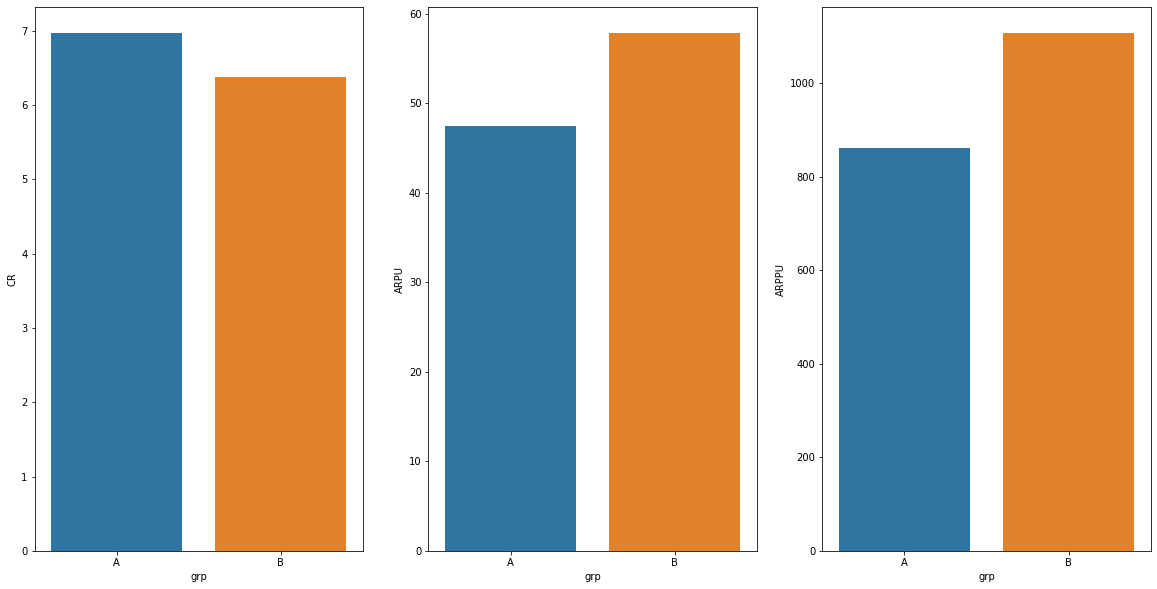

In [33]:
metrics(path_to_file)